In [1]:
import matplotlib.pyplot as plt
import time
from solvers import *

In [2]:
n = 100
m = 100
density = 0.1  # Probability of observing each entry

# seed
seed = int(time.time())

# Generate synthetic problem
X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density,
                                                                 seed - 1)  # seed-1 to avoid overlap with the gaussian initialization seed as they'd be the same otherwise

In [3]:
from sklearn.decomposition import TruncatedSVD


def compare_solvers(X_obs, X_true, u0, v0, mask, lambda_als=None, gd_params=None, plot=False, verbose=True):
    """
    Compare the performance of Alternating Optimization (AO), AO with normalization and Gradient Descent.

    :param X_obs: Incomplete matrix (n x n), missing entries as zeros
    :param X_true: Ground truth matrix (n x n)
    :param u0: Initial guess for vector u (n,).
    :param v0: Initial guess for vector v (n,).
    :param mask: Binary mask of observed entries (n x n), dtype=bool
    :param lambda_als: Regularization strength for AO and AON as a list
    :param gd_params: Gradient descent parameters as a list [lr, lambda_reg]
    :param plot: If True, plot residual curves
    """

    if lambda_als is None:
        lambda_als = [0.403, 1.5e-2]

    if verbose:
        print("=== Alternating Optimization (AO) ===")
    start = time.time()
    u, v, it, res, hist = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=1500,
        lambda_reg=lambda_als[0], verbose=False, track_residuals=plot
    )
    end = time.time()
    time_als = end - start
    ao_sol = np.outer(u, v)
    observed_error_ao = np.linalg.norm((ao_sol - X_true) * mask, 'fro')
    full_error_ao = np.linalg.norm(ao_sol - X_true, 'fro')
    if verbose:
        print(
            f"AO: Residual={res:.6f}, Observed Error={observed_error_ao:.8f}, Full Error={full_error_ao:.8f}, Iter={it}, Time={end - start:.4f}s")

    if verbose:
        print("\n=== AO with Normalization (AON) ===")
    start = time.time()
    u, v, it, res, hist2 = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=1500,
        lambda_reg=lambda_als[1], norm_v=True, verbose=False, track_residuals=plot
    )
    end = time.time()
    time_aon = end - start
    aon_sol = np.outer(u, v)
    observed_error_aon = np.linalg.norm((aon_sol - X_true) * mask, 'fro')
    full_error_aon = np.linalg.norm(aon_sol - X_true, 'fro')
    if verbose:
        print(
            f"AON: Residual={res:.6f}, Observed Error={observed_error_aon:.8f}, Full Error={full_error_aon:.8f}, Iter={it}, Time={end - start:.4f}s")

    if verbose:
        print("\n=== Gradient Descent (GD) ===")
    if gd_params is None:
        gd_params = [9.41e-04, 6.95e-05]
    lr = gd_params[0]
    lambda_gd = gd_params[1]
    start = time.time()
    u, v, it, res, hist3 = gradient_descent_rank1(
        X_obs, mask, u_init=u0.copy(), v_init=v0.copy(),
        max_it=1500, lr=lr, lambda_reg=lambda_gd,
        tol=1e-8, verbose=False, track_residuals=plot
    )
    end = time.time()
    time_gd = end - start
    gd_sol = np.outer(u, v)
    observed_error_gd = np.linalg.norm((gd_sol - X_true) * mask, 'fro')
    full_error_gd = np.linalg.norm(gd_sol - X_true, 'fro')
    if verbose:
        print(
            f"GD: Residual={res:.6f}, Observed Error={observed_error_gd:.8f}, Full Error={full_error_gd:.8f}, Iter={it}, Time={end - start:.4f}s")

    # Plot residuals if available
    if plot:
        plt.figure(figsize=(10, 6))
        if hist and hist['objective']:
            plt.plot(hist['objective'], label='AO Observed Error')
        if hist2 and hist2['objective']:
            plt.plot(hist2['objective'], label='AON Observed Error')
        if hist3:
            plt.plot(hist3, label='GD Observed Error')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Frobenius Error on Observed Entries')
        plt.title('Convergence Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the residuals
        plt.figure(figsize=(10, 6))
        if hist and hist['residuals']:
            plt.plot(hist['residuals'], label='AO Residuals')
        if hist2 and hist2['residuals']:
            plt.plot(hist2['residuals'], label='AON Residuals')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title('Residuals Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # group the results in a dictionary
    results = {
        'AO': {
            'observed_error': observed_error_ao,
            'full_error': full_error_ao,
            'time': time_als,
        },
        'AON': {
            'observed_error': observed_error_aon,
            'full_error': full_error_aon,
            'time': time_aon,
        },
        'GD': {
            'observed_error': observed_error_gd,
            'full_error': full_error_gd,
            'time': time_gd,
        }
    }
    return results


# Baseline using Truncated SVD with imputed values
print("\n=== Truncated SVD ===")
X_filled = X_obs.copy()
X_filled[~mask] = X_obs[mask].mean()  # mean imputation
start = time.time()
svd = TruncatedSVD(n_components=1)
U = svd.fit_transform(X_filled)
V = svd.components_
svd_sol = U @ V
end = time.time()
observed_error_svd = np.linalg.norm((svd_sol - X_true) * mask, 'fro')
full_error_svd = np.linalg.norm(svd_sol - X_true, 'fro')
print(f"SVD: Observed Error={observed_error_svd:.6f}, Full Error={full_error_svd:.6f}, Time={end - start:.4f}s")


=== Truncated SVD ===
SVD: Observed Error=22.294407, Full Error=75.278406, Time=0.0145s


=== Gaussian Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=1.558624, Observed Error=1.55862425, Full Error=9.07930308, Iter=168, Time=0.3587s

=== AO with Normalization (AON) ===
AON: Residual=8.115910, Observed Error=8.11590994, Full Error=134.03896858, Iter=5, Time=0.0085s

=== Gradient Descent (GD) ===
GD: Residual=118.683900, Observed Error=2.86301680, Full Error=14.97288539, Iter=570, Time=0.0257s


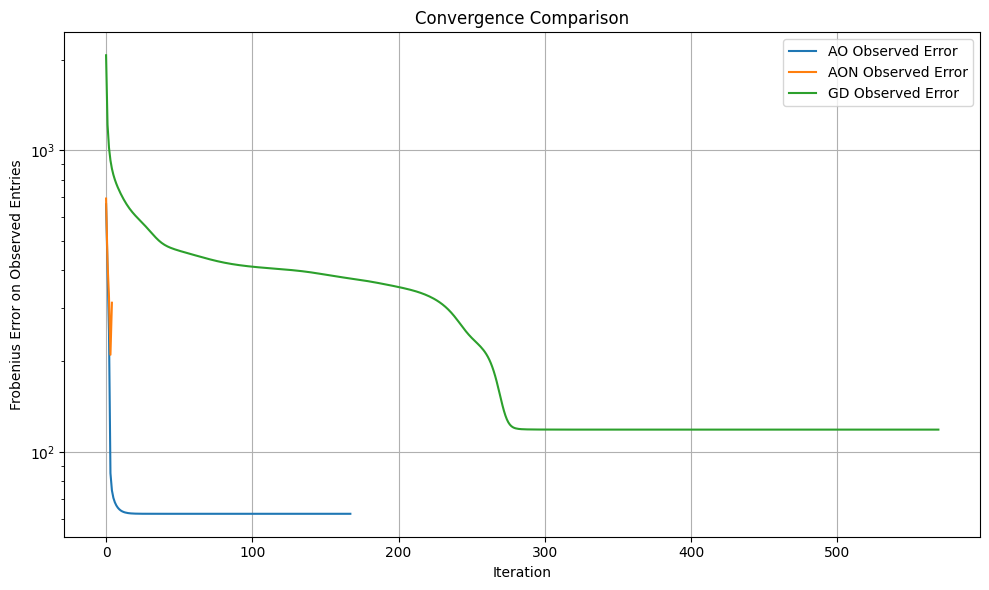

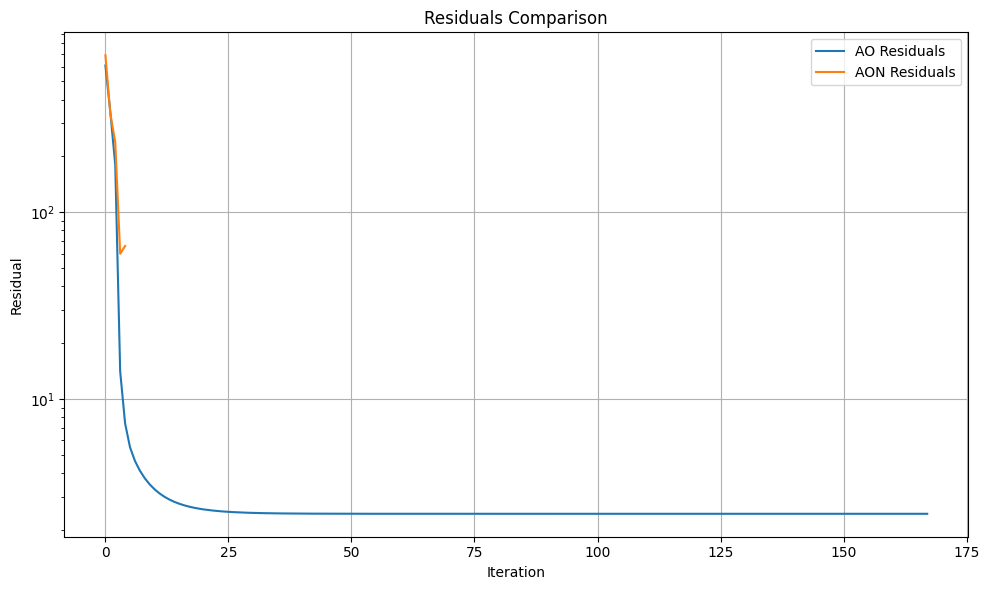

In [4]:
# Benchmark the different initialization strategies
print("=== Gaussian Initialization ===")
u0_g, v0_g = initialize_uv(X_obs, mask, strategy='gaussian', seed=seed)
# Benchmark the different solvers
gauss = compare_solvers(X_obs, X_true, u0_g.copy(), v0_g.copy(), mask, plot=True, gd_params=[9e-3, 7.94e-01])


=== SVD Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=0.000000, Observed Error=0.00000012, Full Error=0.00000082, Iter=43, Time=0.0847s

=== AO with Normalization (AON) ===
AON: Residual=0.000000, Observed Error=0.00000003, Full Error=0.00000022, Iter=62, Time=0.1143s

=== Gradient Descent (GD) ===
GD: Residual=0.000002, Observed Error=0.00080930, Full Error=0.01196277, Iter=842, Time=0.0317s


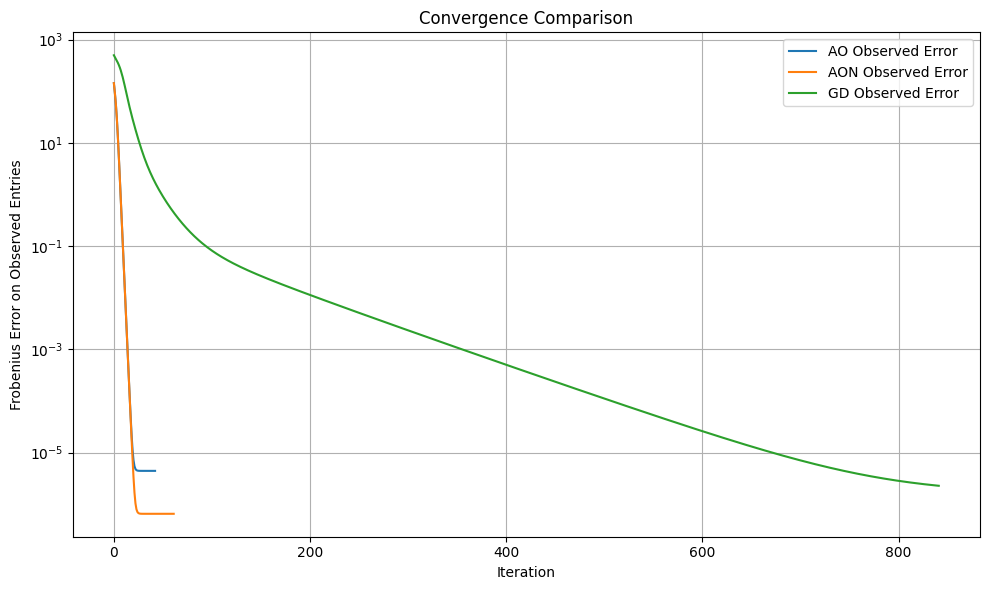

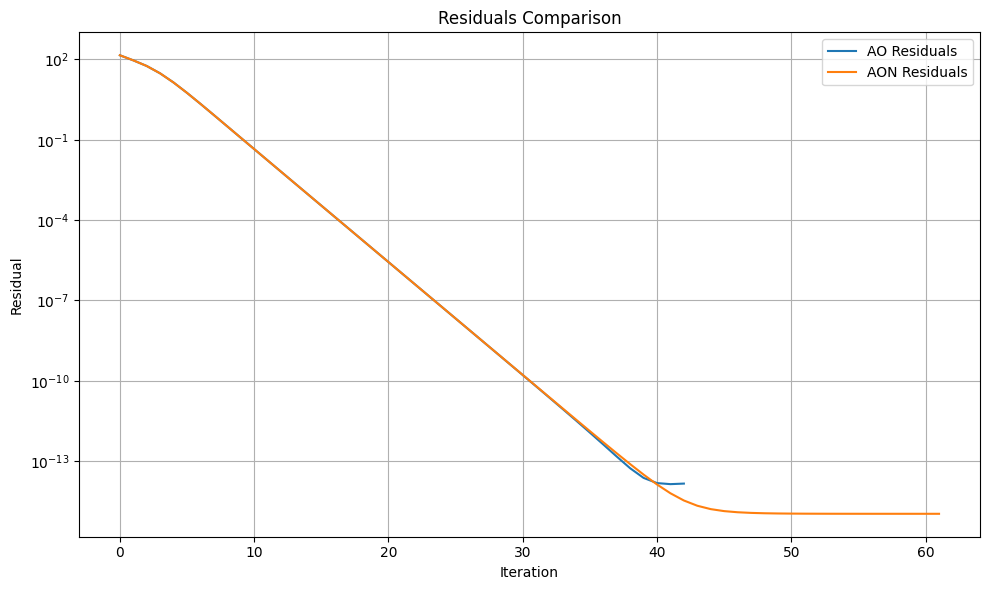

In [5]:
print("\n=== SVD Initialization ===")
u0_s, v0_s = initialize_uv(X_obs, mask, strategy='svd', seed=seed)
svd = compare_solvers(X_obs, X_true, u0_s.copy(), v0_s.copy(), mask, lambda_als=[1e-8, 1e-10],
                      gd_params=[1e-02, 1e-08], plot=True)


=== SVD + Noise Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=0.000000, Observed Error=0.00000023, Full Error=0.00000160, Iter=40, Time=0.0767s

=== AO with Normalization (AON) ===
AON: Residual=0.000000, Observed Error=0.00000003, Full Error=0.00000022, Iter=60, Time=0.1439s

=== Gradient Descent (GD) ===
GD: Residual=0.000002, Observed Error=0.00081206, Full Error=0.01200312, Iter=843, Time=0.0503s


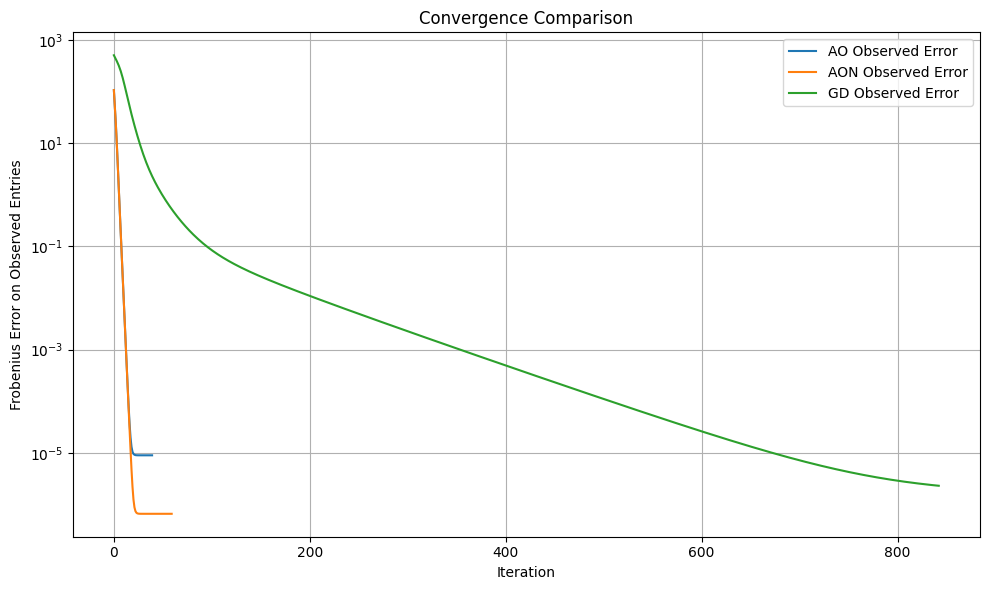

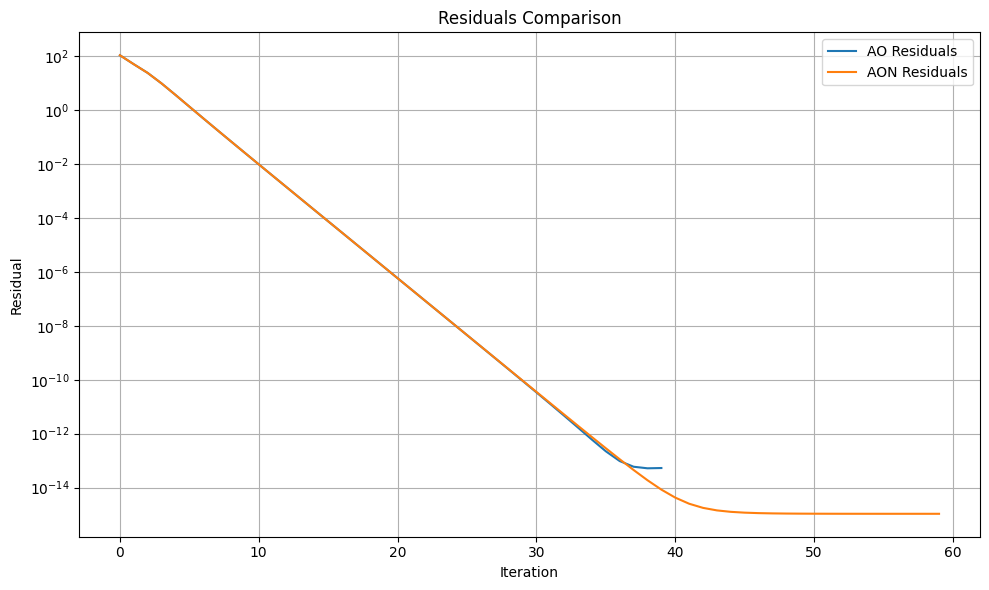

In [6]:
print("\n=== SVD + Noise Initialization ===")
u0_sn, v0_sn = initialize_uv(X_obs, mask, strategy='svd', epsilon=0.1, seed=seed)
svd_n = compare_solvers(X_obs, X_true, u0_sn.copy(), v0_sn.copy(), mask, lambda_als=[3e-8, 1e-10],
                        gd_params=[1e-02, 1e-8], plot=True)


=== Mean Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=3.511721, Observed Error=3.51172095, Full Error=17.62354438, Iter=77, Time=0.1489s

=== AO with Normalization (AON) ===
AON: Residual=1.473794, Observed Error=1.47379436, Full Error=7.77742422, Iter=49, Time=0.1112s

=== Gradient Descent (GD) ===
GD: Residual=451.237589, Observed Error=21.23779087, Full Error=91.81775462, Iter=1500, Time=0.0736s


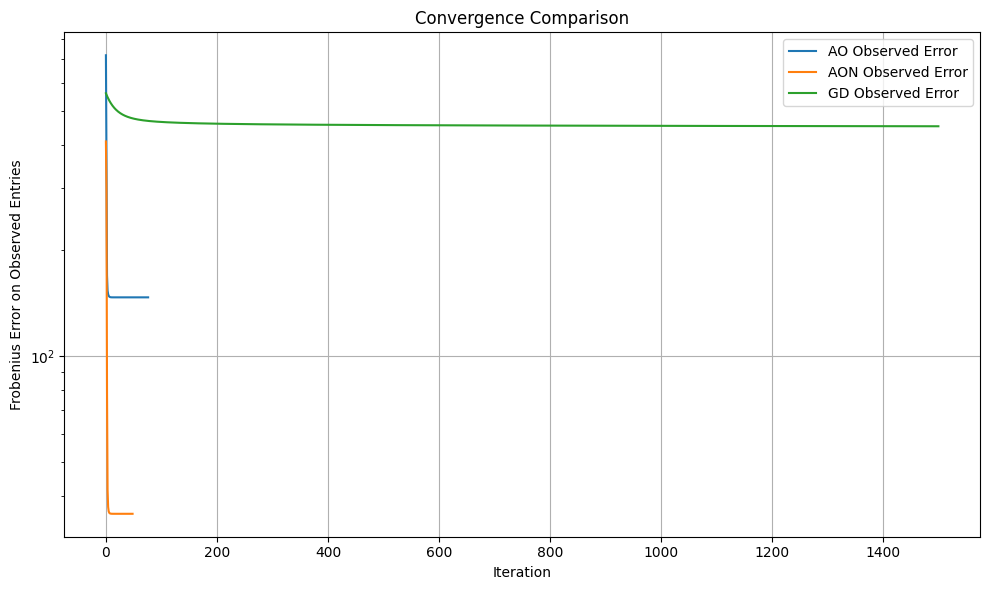

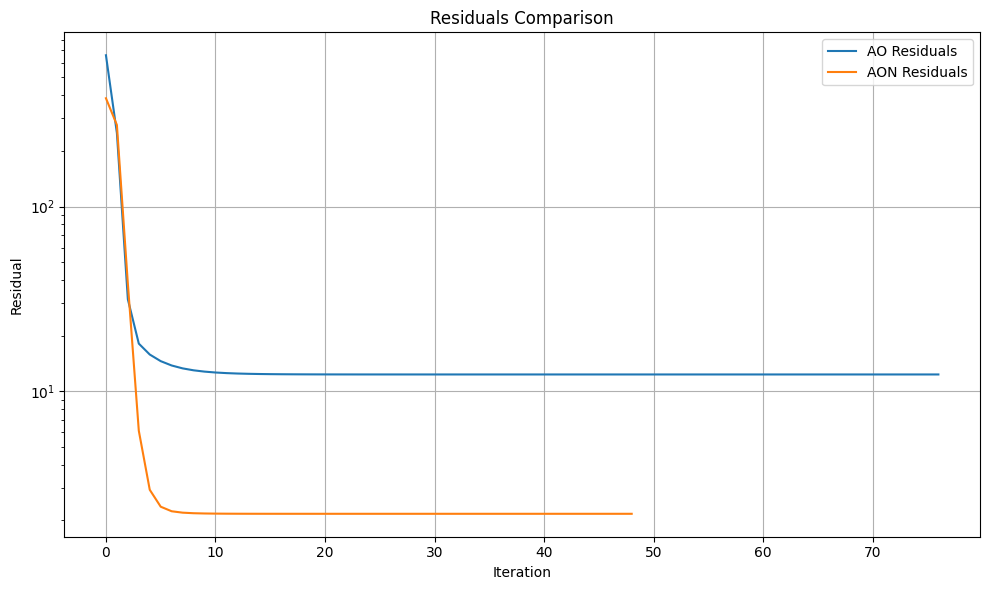

In [7]:
print("\n=== Mean Initialization ===")
u0_m, v0_m = initialize_uv(X_obs, mask, strategy='mean', seed=seed)
mean = compare_solvers(X_obs, X_true, u0_m.copy(), v0_m.copy(), mask, lambda_als=[1e-0, 5.80e-03],
                       gd_params=[3.16e-05, 8.86e-05], plot=True)

In [8]:
# compare the results of the different initializations and solvers in a table
import pandas as pd
from tabulate import tabulate

# Create a DataFrame to store the results
results_ao = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['AO']['observed_error'],
        svd['AO']['observed_error'],
        svd_n['AO']['observed_error'],
        mean['AO']['observed_error']
    ],
    'Full Error': [
        gauss['AO']['full_error'],
        svd['AO']['full_error'],
        svd_n['AO']['full_error'],
        mean['AO']['full_error']
    ],
    'Time': [
        gauss['AO']['time'],
        svd['AO']['time'],
        svd_n['AO']['time'],
        mean['AO']['time']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_ao, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization (AO) ===")
print(table_str)

results_aon = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['AON']['observed_error'],
        svd['AON']['observed_error'],
        svd_n['AON']['observed_error'],
        mean['AON']['observed_error']
    ],
    'Full Error': [
        gauss['AON']['full_error'],
        svd['AON']['full_error'],
        svd_n['AON']['full_error'],
        mean['AON']['full_error']
    ],
    'Time': [
        gauss['AON']['time'],
        svd['AON']['time'],
        svd_n['AON']['time'],
        mean['AON']['time']
    ]
})

# Convert the DataFrame to a string table
table_str = tabulate(results_aon, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization with Normalization (AON) ===")
print(table_str)

results_gd = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['GD']['observed_error'],
        svd['GD']['observed_error'],
        svd_n['GD']['observed_error'],
        mean['GD']['observed_error']
    ],
    'Full Error': [
        gauss['GD']['full_error'],
        svd['GD']['full_error'],
        svd_n['GD']['full_error'],
        mean['GD']['full_error']
    ],
    'Time': [
        gauss['GD']['time'],
        svd['GD']['time'],
        svd_n['GD']['time'],
        mean['GD']['time']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_gd, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Gradient Descent (GD) ===")
print(table_str)


=== Alternating Optimization (AO) ===
+-------------+------------------------+-----------------------+---------------------+
|   Method    |     Observed Error     |      Full Error       |        Time         |
+-------------+------------------------+-----------------------+---------------------+
|  Gaussian   |   1.5586242511669417   |   9.079303078293025   | 0.35872435569763184 |
|     SVD     | 1.199315776320137e-07  | 8.198269444655636e-07 | 0.08466696739196777 |
| SVD + Noise | 2.3083447907158022e-07 | 1.601258221155505e-06 | 0.07669496536254883 |
|    Mean     |   3.5117209481672433   |  17.623544378173207   | 0.14887189865112305 |
+-------------+------------------------+-----------------------+---------------------+
=== Alternating Optimization with Normalization (AON) ===
+-------------+------------------------+------------------------+----------------------+
|   Method    |     Observed Error     |       Full Error       |         Time         |
+-------------+---------------

In [11]:
init_settings = {
    'gaussian': {
        'lambda_als': [0.403, 1.5e-2],
        'gd_params': [9e-3, 7.94e-01]
    },
    'svd': {
        'lambda_als': [1e-8, 1e-10],
        'gd_params': [1e-02, 1e-08]
    },
    'svd+noise': {
        'lambda_als': [3e-8, 1e-10],
        'gd_params': [1e-02, 1e-8]
    },
    'mean': {
        'lambda_als': [1e-0, 5.80e-03],
        'gd_params': [3.16e-05, 8.86e-05]
    }
}


def run_benchmark_for_seed(seed, density=0.1, m=100, n=100):
    """
    Run the benchmark for a given seed over the different solvers and initialization strategies.
    :param seed: Random seed for reproducibility
    :param density: Density of the observed entries in the matrix
    :param m: Number of rows in the matrix
    :param n: Number of columns in the matrix
    :return: Dictionary containing the results for each method
    """

    X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density, seed=seed - 1)
    results = {}

    for strategy_key in ['gaussian', 'svd', 'svd+noise', 'mean']:
        pretty_name = strategy_key.replace('+', ' + ').capitalize()

        if strategy_key == 'svd+noise':
            u0, v0 = initialize_uv(X_obs, mask, strategy='svd', epsilon=1e-4, seed=seed)
        else:
            u0, v0 = initialize_uv(X_obs, mask, strategy=strategy_key, seed=seed)

        # Get strategy-specific parameters
        params = init_settings[strategy_key]
        lambda_als = params['lambda_als']
        gd_params = params['gd_params']

        results[pretty_name] = compare_solvers(
            X_obs, X_true, u0.copy(), v0.copy(), mask,
            lambda_als=lambda_als, gd_params=gd_params, plot=False, verbose=False
        )

    return results

def summarize_solver_results(solver):
    rows = []
    for method in ['Gaussian', 'Svd', 'Svd + noise', 'Mean']:
        obs = np.mean(accum_results[method][f'{solver}_obs'])
        full = np.mean(accum_results[method][f'{solver}_full'])
        time = np.mean(accum_results[method][f'{solver}_time'])
        rows.append({
            'Method': method,
            'Observed Error': obs,
            'Full Error': full,
            'Time': time
        })
    return pd.DataFrame(rows)

In [18]:
from collections import defaultdict

# Structure: method -> solver -> list of errors
accum_results = defaultdict(lambda: defaultdict(list))

for seed in range(20):
    seed_results = run_benchmark_for_seed(seed+1, density=0.1, m=m, n=n)
    for method, solvers in seed_results.items():
        for solver, vals in solvers.items():
            accum_results[method][f'{solver}_obs'].append(vals['observed_error'])
            accum_results[method][f'{solver}_full'].append(vals['full_error'])
            accum_results[method][f'{solver}_time'].append(vals['time'])


# === PRINT TABLES ===
for solver in ['AO', 'AON', 'GD']:
    print(f"=== {solver} ===")
    df = summarize_solver_results(solver)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    print()

=== AO ===
+-------------+------------------------+-----------------------+---------------------+
|   Method    |     Observed Error     |      Full Error       |        Time         |
+-------------+------------------------+-----------------------+---------------------+
|  Gaussian   |   7.438226974026446    |  63.339658208940094   | 0.19138743877410888 |
|     Svd     | 2.1071633606516356e-07 | 3.181505502427222e-06 | 0.10858657360076904 |
| Svd + noise | 6.335819423474166e-07  | 9.559519760070476e-06 | 0.09877461194992065 |
|    Mean     |   7.180550192547576    |  41.869281650096305   | 0.06414779424667358 |
+-------------+------------------------+-----------------------+---------------------+

=== AON ===
+-------------+-----------------------+------------------------+----------------------+
|   Method    |    Observed Error     |       Full Error       |         Time         |
+-------------+-----------------------+------------------------+----------------------+
|  Gaussian   | 

In [19]:
for seed in range(20):
    seed_results = run_benchmark_for_seed(seed+1, density=0.2, m=m, n=n)
    for method, solvers in seed_results.items():
        for solver, vals in solvers.items():
            accum_results[method][f'{solver}_obs'].append(vals['observed_error'])
            accum_results[method][f'{solver}_full'].append(vals['full_error'])
            accum_results[method][f'{solver}_time'].append(vals['time'])


# === PRINT TABLES ===
for solver in ['AO', 'AON', 'GD']:
    print(f"=== {solver} ===")
    df = summarize_solver_results(solver)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    print()

=== AO ===
+-------------+------------------------+------------------------+---------------------+
|   Method    |     Observed Error     |       Full Error       |        Time         |
+-------------+------------------------+------------------------+---------------------+
|  Gaussian   |   4.238747409796593    |   33.27378907666709    | 0.3820334136486053  |
|     Svd     | 1.2143879230937724e-07 | 1.6493752515219533e-06 | 0.0815479040145874  |
| Svd + noise | 3.6485825544012454e-07 | 4.9549645532379795e-06 | 0.07410378456115722 |
|    Mean     |    5.57767843155531    |   27.944595717901894   | 0.15236441493034364 |
+-------------+------------------------+------------------------+---------------------+

=== AON ===
+-------------+------------------------+------------------------+----------------------+
|   Method    |     Observed Error     |       Full Error       |         Time         |
+-------------+------------------------+------------------------+----------------------+
|  Ga

In [17]:
for seed in range(20):
    seed_results = run_benchmark_for_seed(seed+1, density=0.5, m=m, n=n)
    for method, solvers in seed_results.items():
        for solver, vals in solvers.items():
            accum_results[method][f'{solver}_obs'].append(vals['observed_error'])
            accum_results[method][f'{solver}_full'].append(vals['full_error'])
            accum_results[method][f'{solver}_time'].append(vals['time'])


# === PRINT TABLES ===
for solver in ['AO', 'AON', 'GD']:
    print(f"=== {solver} ===")
    df = summarize_solver_results(solver)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    print()

=== AO ===
+-------------+--------------------+--------------------+---------------------+
|   Method    |   Observed Error   |     Full Error     |        Time         |
+-------------+--------------------+--------------------+---------------------+
|  Gaussian   | 4.546465101546647  | 44.563274582246535 | 0.6910216033458709  |
|     Svd     | 0.6081056898351593 | 41268.04982040784  | 0.6071017652750015  |
| Svd + noise | 0.6068267454912508 | 25039.293885071387 | 0.6552040904760361  |
|    Mean     | 5.717409267153817  | 39.437220320783226 | 0.28243130445480347 |
+-------------+--------------------+--------------------+---------------------+

=== AON ===
+-------------+--------------------+--------------------+---------------------+
|   Method    |   Observed Error   |     Full Error     |        Time         |
+-------------+--------------------+--------------------+---------------------+
|  Gaussian   |  7.00819921255403  | 56.638672583272026 |  0.019196817278862  |
|     Svd     | 

In [20]:
for seed in range(20):
    seed_results = run_benchmark_for_seed(seed+1, density=0.05, m=m, n=n)
    for method, solvers in seed_results.items():
        for solver, vals in solvers.items():
            accum_results[method][f'{solver}_obs'].append(vals['observed_error'])
            accum_results[method][f'{solver}_full'].append(vals['full_error'])
            accum_results[method][f'{solver}_time'].append(vals['time'])


# === PRINT TABLES ===
for solver in ['AO', 'AON', 'GD']:
    print(f"=== {solver} ===")
    df = summarize_solver_results(solver)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    print()

C:\Users\alext\Desktop\Uni\CM\solvers.py:255: RuntimeWarning: overflow encountered in multiply
  pred_obs = u[obs_i] * v[obs_j]  # element-wise product u_i * v_j
C:\Users\alext\Desktop\Uni\CM\solvers.py:261: RuntimeWarning: overflow encountered in multiply
  np.add.at(grad_u, obs_i, 2 * resid_obs * v[obs_j])
C:\Users\alext\Desktop\Uni\CM\solvers.py:266: RuntimeWarning: overflow encountered in multiply
  np.add.at(grad_v, obs_j, 2 * resid_obs * u[obs_i])
C:\Users\alext\Desktop\Uni\CM\solvers.py:274: RuntimeWarning: overflow encountered in square
  loss = np.sum(resid_obs ** 2)
C:\Users\alext\Desktop\Uni\CM\solvers.py:285: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(prev_obj - obj) < tol:
C:\Users\alext\Desktop\Uni\CM\solvers.py:270: RuntimeWarning: invalid value encountered in subtract
  u -= lr * grad_u
C:\Users\alext\Desktop\Uni\CM\solvers.py:271: RuntimeWarning: invalid value encountered in subtract
  v -= lr * grad_v


=== AO ===
+-------------+--------------------+--------------------+---------------------+
|   Method    |   Observed Error   |     Full Error     |        Time         |
+-------------+--------------------+--------------------+---------------------+
|  Gaussian   | 5.865974586011961  | 59.120473105997284 | 0.32608720858891804 |
|     Svd     | 0.8108075833334325 | 55024.06642720543  | 0.8612453619639079  |
| Svd + noise | 0.8091023179834996 | 33385.72518008013  | 0.9323687752087911  |
|    Mean     | 7.137485599554858  | 51.84742023914809  | 0.12309697071711222 |
+-------------+--------------------+--------------------+---------------------+

=== AON ===
+-------------+--------------------+--------------------+----------------------+
|   Method    |   Observed Error   |     Full Error     |         Time         |
+-------------+--------------------+--------------------+----------------------+
|  Gaussian   | 8.687331533802556  | 74.55668174584277  | 0.021145097414652505 |
|     Svd   